Imports and mesa installation

In [1]:
!pip install mesa
import random as rand
import math as m
import numpy as np
import pandas as pd
from mesa import Agent, Model
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid
from mesa.time import BaseScheduler
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from mesa.space import MultiGrid
import matplotlib.pyplot as searchModelPlt
import matplotlib.pyplot as plt
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.8 MB/s eta 0:00:00


Crash simulation

In [2]:
class Airplane(Agent):

  def __init__(self, unique_id, model, altitude, speed):
    super().__init__(unique_id, model)
    self.xPos = 0
    self.yPos = 0 
    self.zPos = altitude
    #Using spherical cooridnates in radians as that is what python uses to determine x,y,x velocity componetnts
    #velocity is in meters/minute as each tick is one min
    self.yaw = 0 #units are knots 
    self.pitch = m.pi/2 #polar coordinates
    #change speed from knots to (1/2)km / min
    self.speed = speed*(0.01543)# (1/2)km / min
    self.xVelocity = speed
    self.yVelocity = 0
    self.zVelocity = -10
    #this is how many degrees we expect the aircraft to drift in either direction each tick
    self.driftCoefYaw = m.radians(.005)
    self.driftCoefPitch = m.radians(.001)

  def updateVelocities(self):
    #this one allows for faster simulation run times
    self.zVelcoityCoef = (1/60)*6800
    #this one is more accuratly scaled to reality 
    #self.zVelcoityCoef = 0.01543

    self.updateHeading()
    #updating the speed based on the heading
    self.xVelocity = self.speed*m.cos(self.yaw)
    self.yVelocity = self.speed*m.sin(self.yaw)
    #the minus pi/2 is to shift to proper coordinate space 
    self.zVelocity = self.speed*(self.zVelcoityCoef)*m.tan(m.pi/2 - self.pitch)
    
  #update the expected velocities based on eqs and random varriation 
  def updateHeading(self):
    self.yaw += rand.uniform(-self.driftCoefYaw, self.driftCoefYaw)
    #the reason the lower bound is zero is because it doesnt make sense for an airplane with no power to pitch up and not stall so I think we can assume the pilot wouldn't do that
    self.pitch += rand.uniform(0, self.driftCoefPitch)

  #each tick is 1 minute
  def step(self):

    self.updateVelocities()
    if(self.zPos > 0):
      self.xPos += self.xVelocity
      self.yPos += self.yVelocity 
      self.zPos += self.zVelocity
      #print("Postion " + str(self.xPos) + ", " + str(self.yPos) + ", " + str(self.zPos))


class CrashModel(Model):

  def __init__(self,N):
    self.num_agents = N
    self.schedule = BaseScheduler(self)
    for i in range(self.num_agents):
      p = Airplane(i,self,1000,100)
      self.schedule.add(p)

  def step(self):
    """Advance the model by one step."""
    self.schedule.step()

  def run_model(self) -> None:
      while (self.schedule.agents[0].zPos > 0):
        #print(self.schedule.agents[0].zPos)
        self.step()
      

  def crashRangeX(self, input):
    min = m.inf
    for p in input:
      if(p.xPos < min):
        min = p.xPos
    max = -m.inf
    for p in input:
      if(p.xPos > max):
        max = p.xPos
    
    #the + 1 is too prevent array index out of bounds exception
    return max - min + 1

  def crashRangeY(self, input):
    min = m.inf
    for p in input:
      if(p.yPos < min):
        min = p.yPos
    max = -m.inf
    for p in input:
      if(p.yPos > max):
        max = p.yPos
    
    #the + 1 is too prevent array index out of bounds exception
    return max - min + 1
  
  def averageXPos(self):
    sum = 0
    for p in self.schedule.agents:
      sum += p.xPos
    
    return sum / self.num_agents

  def averageYPos(self):
    sum = 0
    for p in self.schedule.agents:
      sum += p.yPos
    
    return sum / self.num_agents

  def stdX(self):
    avr = self.averageXPos()
    sum = 0
    for p in self.schedule.agents:
      sum += abs(avr - p.xPos)
    
    return sum / self.num_agents

  def stdY(self):
    avr = self.averageYPos()
    sum = 0
    for p in self.schedule.agents:
      sum += abs(avr - p.yPos)
    
    return sum / self.num_agents

  def xMin(self,input):
    min = m.inf;
    for p in input:
      if(p.xPos < min):
        min = p.xPos
    return min

  def yMin(self,input):
    min = m.inf
    for p in input:
      if(p.yPos < min):
        min = p.yPos
    return min

  def isOutlier(self,x,y):
    #any plane with x and y vals outside this number of standard devation will be removed from the probability map
    numStdIncluded = 2
    topX = self.averageXPos() + numStdIncluded * self.stdX()
    bottomX = self.averageXPos() - numStdIncluded * self.stdX()
    topY = self.averageYPos() + numStdIncluded * self.stdY()
    bottomY = self.averageYPos() - numStdIncluded * self.stdY()
    return ((x >= topX and y >= topY) or (x <= bottomX and y <= bottomY))

  def removeOutliers(self):

    self.standardXDev = self.stdX()

    self.standardYDev = self.stdY()

    removedOutliers = list()

    for p in self.schedule.agents:
      if(not self.isOutlier(p.xPos, p.yPos)):
        removedOutliers.append(p)
    
    return removedOutliers

  def probabilityMap(self):

    noOutliers = self.removeOutliers()    
    print("x min: " + str(self.xMin(noOutliers)))
    print("y min: " + str(self.yMin(noOutliers)))
    print("x range: " + str(self.crashRangeX(noOutliers)))
    print("y range: " + str(self.crashRangeY(noOutliers)))
    xShift = int(self.xMin(noOutliers))
    print("calculated x shift")
    yShift = int(self.yMin(noOutliers))
    print("calculated y shift")
    map = np.zeros(shape=(int(self.crashRangeX(noOutliers)) + 1, int(self.crashRangeY(noOutliers)) + 1))
    print("init array with size: " + str(map.shape))

    for p in noOutliers:
      #print("new x pos: " + str(p.xPos - xShift + 1) + ("new y pos: " + str(p.yPos - yShift + 1)))
      map[int(p.xPos - xShift), int(p.yPos - yShift)] += 1

    #return map / self.num_agents
    return map

  def squareProbabilityMap(self):
    return


This is where you run the crash model

You can simulate as many airplanes as you wish but google colab is only really able to handle up to about 5000 airplanes

In [3]:
#the number you put into the crash model is the number of airplanes you want to simulate
crashModel = CrashModel(100)

#Calling this runs the model then you can get the probability map for it
crashModel.run_model()

#!!!!!!!!!LOOK HERE!!!!!!!!!####
#take this and make it into a heat map
probabilityMap = crashModel.probabilityMap()
print(probabilityMap)

x min: 1732.787097610812
y min: -3.0741864456075176
x range: 44.205808917891545
y range: 8.20400718286714
calculated x shift
calculated y shift
init array with size: (45, 9)
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  2.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  2.  0.  0.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  1.  1.  2.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  1.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  

Statistics for the crash model

In [4]:
print("Average x: " +  str(crashModel.averageXPos()) + " y: " + str(crashModel.averageYPos()))
print("Standard Deviation x: " + str(crashModel.stdX()) + " y: " + str(crashModel.stdY()))
xMax = crashModel.xMin(crashModel.schedule.agents) + crashModel.crashRangeX(crashModel.schedule.agents)
yMax = crashModel.yMin(crashModel.schedule.agents) + crashModel.crashRangeY(crashModel.schedule.agents)
print("X min: " + str(crashModel.xMin(crashModel.schedule.agents)) + "X max: " + str(xMax))
print("Y min: " + str(crashModel.yMin(crashModel.schedule.agents)) + "Y max: " + str(yMax))
print("Range x: " + str(crashModel.crashRangeX(crashModel.schedule.agents)) + " y: " + str(crashModel.crashRangeY(crashModel.schedule.agents)))

Average x: 1763.1234341778647 y: 0.17529461889849443
Standard Deviation x: 10.905278759705674 y: 1.1543879313396044
X min: 1732.787097610812X max: 1776.9929065287035
Y min: -3.0741864456075176Y max: 5.129820737259623
Range x: 44.205808917891545 y: 8.20400718286714


Creating a heat map from the frequency map

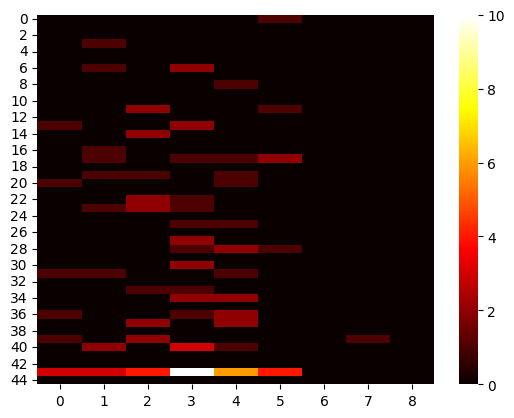

In [5]:
sns.heatmap(probabilityMap,cmap='hot')
plt.show()

Search Simulation

In [6]:
class AUV(Agent):
  def __init__(self, unique_id, model, crashModel, probabilityMap, airplane):
    super().__init__(unique_id, model)  
    self.probMap = probabilityMap
    self.crashModel = crashModel
    #we had accutal values for these but i forgor
    self.resetTime = 60 # 60 ticks for climb, descend and data extraction
    self.searchTime = 180 # searching ocean floor
    self.timeTracker = 240 # total time for daliy mission
    self.isSearching = True
    self.alreadySearched = list()
    self.findStartPos()
    self.hasLocatedBox = False
    self.trueXLoc = int(airplane.xPos)
    self.trueYLoc = int(airplane.yPos)

  def findStartPos(self):
    tempRow = 0
    tempColumn = 0
    max = 0

    for i in range(self.probMap.shape[0]):
      for j in range(self.probMap.shape[1]):
        if(self.probMap[i,j] > max):
          max = self.probMap[i,j]
          tempRow = i
          tempColumn = j
    
    self.row = tempRow
    self.column = tempColumn
    self.alreadySearched.append(np.array([tempRow,tempColumn]))
    #print("Current List: " + str(self.alreadySearched))
    #print("Starting Position: " + str(self.row) + ", " + str(self.column))

  def isValidPath(self,row,column):
    #print("Row: " + str(row) + " Column: " + str(column))
    isNotOutOfBounds = (row >= 0 and column >= 0 and row < self.probMap.shape[0] and column < self.probMap.shape[1])
    hasNotVisited = not self.hasVisited(row,column)
    #print("Is not out of bounds: " + str(isNotOutOfBounds))
    #print("Is path valid: " + str(isNotOutOfBounds & hasNotVisited))
    return isNotOutOfBounds and hasNotVisited

  def hasVisited(self,row,column):
    for a in self.alreadySearched:
      if(a[0] == row and a[1] == column):
        #print("have been here already")
        return True
    #print("have not been here")
    return False


  def findNextStep(self):
    validPaths = list()

    #finding all of the valid locations the auv can go to
    #print("Looking for valid paths")
    for i in range(self.row - 1, self.row + 2):
      for j in range(self.column - 1, self.column + 2):
        if(self.isValidPath(i,j)):
          #print("adding point: " + str(i) + ", " +  str(j))
          validPaths.append(np.array([i,j]))
            
    #find path with highest probability
    max = 0
    maxP = np.array([0,0])
    for p in validPaths:
      #print("Path: " + str(p))
      if(max < self.probMap[p[0],p[1]]):
        max = self.probMap[p[0],p[1]]
        maxP = p
    
    if(max == 0):
      maxP = self.stepTowardsAverage()
    #print("Max path: " + str(maxP))
    return maxP



  def stepTowardsAverage(self):
    avgRow = int(self.crashModel.averageXPos() - self.crashModel.xMin(self.crashModel.schedule.agents))
    avgColumn = int(self.crashModel.averageYPos() - self.crashModel.yMin(self.crashModel.schedule.agents))

    if(self.row < avgRow):
      newRow = self.row + 1
    else:
      newRow = self.row - 1
    
    if(self.column < avgColumn):
      newColumn = self.column + 1
    else:
      newColumn = self.column - 1

    return np.array([newRow, newColumn])


  def search(self):

    if(self.row == self.trueXLoc & self.column == self.trueYLoc):
      self.hasLocatedBox = True


  def step(self):

    if(self.isSearching):
      self.search()
      #print("Searched area")
      nextStep = self.findNextStep()
      #print("Found next step: " + str(nextStep))
      self.alreadySearched.append(nextStep)
      self.row = nextStep[0]
      self.column = nextStep[1]
      #print("moving to next step")
      if(self.timeTracker > self.searchTime):
        #print("search time limit reached!")
        self.isSearching = False
        self.timeTracker = 0
      self.timeTracker += 1
    else:
      #print("Getting auv ready to search")
      if(self.timeTracker > self.resetTime):
        self.isSearching = True
        self.timeTracker = 0
      self.timeTracker += 1

    #print("The Loc of the auv is: " + str(self.row) + ", " + str(self.column))

class SearchSimulation(Model):
  def __init__(self,crashModel, probabilityMap,airplane):
    super().__init__()
    self.num_agents = 1
    self.schedule = BaseScheduler(self)
    auv = AUV(0, self, crashModel, probabilityMap, airplane)
    self.schedule.add(auv)

  def step(self):
    self.schedule.step()

  def run_model(self) -> None:
    #this is how long in ticks we have until the box stops emmitting a signal
    signalLength = 1000
    for i in range(signalLength):
      #print("current tick: " + str(i))
      self.step()
      if(self.schedule.agents[0].hasLocatedBox):
        break
  


This is where you simulate the auv model

In [7]:
airplane = crashModel.schedule.agents[0]

searchModel = SearchSimulation(crashModel,probabilityMap,airplane)

searchModel.run_model()

Outputing the auv search path

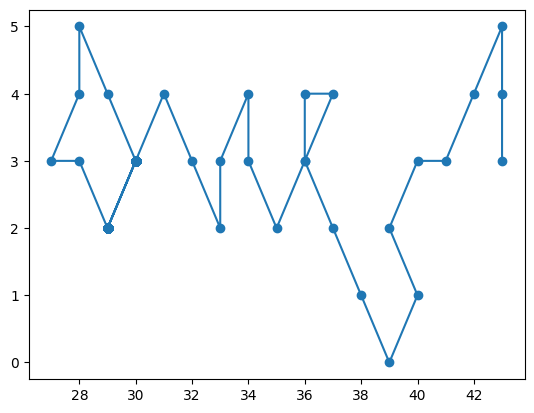

In [8]:
x = np.arange(len(searchModel.schedule.agents[0].alreadySearched))
y = np.arange(len(searchModel.schedule.agents[0].alreadySearched))
i = 0

for h in searchModel.schedule.agents[0].alreadySearched:
  x[i] = h[0]
  y[i] = h[1]
  i += 1


#make the scattter plot change the color of the first and last point in the list in x and y
searchModelPlt.scatter(x,y)
searchModelPlt.plot(x,y)
searchModelPlt.show()



